# **Assignment 3 - Beer Reviews**
## Unstructured Data Analytics - Anitesh Barua
### by Malik Ouda, Noah Placke, Mounika Tarigopula, Sarah Teng, Tim Wong

## **Task A - Scraper**


In [ ]:
from google.colab import drive 
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import requests
import csv
from bs4 import BeautifulSoup, NavigableString, Tag
import logging
import numpy as np

from string import punctuation
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
%%capture
!pip install selenium
!apt-get -q update # to update ubuntu to correctly run apt install
!apt install -yq chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
from selenium import webdriver
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

In [ ]:
from selenium.webdriver.support.ui import WebDriverWait
from selenium.common.exceptions import TimeoutException
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By

In [ ]:
driver = webdriver.Chrome('chromedriver', options=chrome_options)
from IPython.display import clear_output
from bs4 import BeautifulSoup

driver.quit()
driver = webdriver.Chrome('chromedriver', options=chrome_options)
url = 'https://www.beeradvocate.com/beer/top-rated/'
page = requests.get(url)
page_html = page.text
soup_main = BeautifulSoup(page_html, 'html.parser')
beers = soup_main.find_all(class_ = "hr_bottom_light")

In [ ]:
Beers_dataframe = pd.DataFrame(columns = ['Beer_Name', 'Beer_Review', 'Rating'])

In [ ]:
for beer in beers[1::5]:
    beerinfo = beer.find('a')
    beer_link = beer.find('a')['href']
    link = 'https://www.beeradvocate.com'+ str(beer_link)
    beer_page = requests.get(link)
    beer_html = beer_page.text
    soup = BeautifulSoup(beer_html, 'html.parser')
    reviews = soup.find_all(id = 'rating_fullview_content_2')
    for rev in reviews:
        product_name = beerinfo.string
        user_rating = rev.find(class_ = 'BAscore_norm').string 
        for br in rev.find_all('br'):
            if isinstance(br.nextSibling,NavigableString):
                product_review = br.nextSibling
        records = [{'Beer_Name': product_name, 'Beer_Review': product_review, 'Rating':user_rating}]
        Beers_dataframe = Beers_dataframe.append(records)

In [ ]:
Beers_dataframe

,Beer_Name,Beer_Review,Rating
0,Kentucky Brunch Brand Stout,2019 draft and bottle.,4.99
0,Kentucky Brunch Brand Stout,Smell: early morning pancakes and coffee befor...,5
0,Kentucky Brunch Brand Stout,2019 vintage. Pours a very dark brown color wi...,4.53
0,Kentucky Brunch Brand Stout,It's hyped... There is a lot of breweries doin...,1.49
0,Kentucky Brunch Brand Stout,Reviewing 2019 vintage. This pours thick and c...,4.52
...,...,...,...
0,Scaled Up,Look: Hazy pale gold. With a thin white head. ...,4.34
0,Scaled Up,Cloudy like all Trillium unfiltered beers. The...,4.07
0,Scaled Up,"Pale golden, thin head, and very small lacing....",4.07
0,Scaled Up,This is one of the better beers ive had. I had...,4.78


In [ ]:
unique_names = pd.unique(Beers_dataframe['Beer_Name'])
unique_names.size

250

In [ ]:
Beers_dataframe.to_csv('beer_data.csv', index=None)

## **Task B - Find 3 attributes**

In [ ]:
import re
import csv

reviews = []
prod_rev_dict = {}

dir = "/content/drive/Shared drives/Unstructured Data Analytics/Assignment 3"

with open(f'{dir}/beer_data.csv') as f:
    rows = csv.reader(f, delimiter = ',')
    for row in rows:
      reviews.append(row[1])
      if row[0] in prod_rev_dict:
          prod_rev_dict[row[0]].append(row[1])

      else:
          prod_rev_dict[row[0]] = [row[1]]

reviews.pop(0)
reviews[:10]

['2019 draft and bottle.',
 'Smell: early morning pancakes and coffee before work that wakes you up',
 "2019 vintage. Pours a very dark brown color with noticeable sugars coating the glass. Lots of coffee and maple in the nose, not much barrel or heat at all. Very rich and coating mouthfeel with a lot of layers in the flavor. Coffee, espresso, maple, vanilla are in good balance. Not much bourbon or oak if at all noticeable. Really great beer as it's very hard to pull off this many flavors and layers without a dominant flavor. Just missed it a little with not much bourbon or barrel presence aside from the vanilla notes.",
 "It's hyped... There is a lot of breweries doing this style of beer right. For this to be the top rated is kinda nuts... Over rated, over hyped, over priced. I found a lot of other local beers doing it and for much less tbh. I gave it a 1 for overall because it's not worth msrp of $100 whatsoever. The beer that my friends and I brewed is more balanced than this. ",
 "

In [ ]:
stop = stopwords.words('english')
stop += ['like','dont','would','rt', 'im', 'today', 'http', 'amp', 'https', 'let']

def count(elements, a_dict): 

    # if there exists a key as "elements" then 
    # don't increase its value. Lazy but oh well
    if elements in a_dict: 
        a_dict[elements] += 1
   
    # if the dictionary does not have the key as "elements"  
    # then create a key "elements" and assign its value to 1. 
    else:
        # don't add stopwords or single character elements
        if elements not in stop and len(elements) > 1:
            a_dict.update({elements: 1})

def count2(elements, pair_dict):

    if elements in pair_dict:
        pair_dict[elements] += 1
        
    else:
        pair_dict.update({elements: 1})

In [ ]:
word_freq = {}
final_list = []
pair_freq = {}

for post in reviews:
    # here we split the lines into words and append those words to a new list at the end
    post = post.split(' ')
    word_hold = []
    for word in post:
        word = re.sub(r'[^A-Za-z0-9 ]+', '', word)
        word = word.lower()
        word_hold.append(word)

    word_hold = set(word_hold)
    word_hold = list(word_hold)
    
    pairs = []
    for word in word_hold:
        for word2 in word_hold:
            word2 = re.sub(r'[^A-Za-z0-9 ]+', '', word2)
            word2 = word2.lower()
            if word in stop or word2 in stop: continue
            if word == '' or word2 == '': continue
            if word == word2: continue
            pairs.append(tuple(sorted([word, word2])))
        pairs = list(set(pairs))

    for item in pairs:
        count2(item, pair_freq)
    
    for item in word_hold:
        final_list.append(item)

          
for element in final_list:
    count(element, word_freq)

sort_dict = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
sort_dict_10 = sort_dict[:200]
for i in sort_dict_10:
    print(i[0], i[1])

head 1959
beer 1509
taste 1132
bottle 1085
pours 1000
poured 962
one 859
dark 847
glass 783
color 710
black 696
aroma 690
good 654
lacing 652
sweet 651
white 640
nice 621
nose 605
chocolate 595
great 573
well 569
orange 540
flavor 524
light 518
hazy 515
smooth 508
notes 505
finish 502
bourbon 494
mouthfeel 483
thick 483
brown 479
overall 477
coffee 471
feel 459
body 457
vanilla 452
bit 451
little 445
carbonation 443
really 441
fruit 410
flavors 382
stout 371
citrus 365
barrel 363
pour 362
smell 359
best 356
much 348
medium 348
vintage 346
creamy 325
ive 323
thin 319
bitterness 317
big 308
snifter 307
tan 303
malt 293
get 290
full 286
finger 285
balanced 281
oz 281
yellow 277
smells 274
oak 270
abv 263
rich 262
bitter 261
amazing 257
sweetness 256
caramel 256
still 256
time 256
beers 252
hops 251
golden 251
almost 249
slightly 248
canned 248
sour 245
quickly 240
first 239
ipa 237
dry 237
tulip 235
hop 234
retention 229
mouth 229
2018 226
alcohol 225
foam 224
appearance 223
better 222
ta

## **3 Attributes Chosen:**
### Sweet, Light, Fruit(y)


## **Task C - Similarity Analysis**

In [ ]:
import math
import re
from collections import Counter

WORD = re.compile(r"\w+")


def get_cosine(vec1, vec2):
    intersection = set(vec1.keys()) & set(vec2.keys())
    numerator = sum([vec1[x] * vec2[x] for x in intersection])

    sum1 = sum([vec1[x] ** 2 for x in list(vec1.keys())])
    sum2 = sum([vec2[x] ** 2 for x in list(vec2.keys())])
    denominator = math.sqrt(sum1) * math.sqrt(sum2)

    if not denominator:
        return 0.0
    else:
        return float(numerator) / denominator

def text_to_vector(text):
    words = WORD.findall(text)
    return Counter(words)

cust_attr = 'sweet light fruit'
attr_vector = text_to_vector(cust_attr)

prod_names = []
prod_reviews = []
for key in prod_rev_dict:
    for post in prod_rev_dict[key]:
        prod_names.append(key)
        prod_reviews.append(post)

df_scores = pd.DataFrame(data=[prod_names, prod_reviews]).T
df_scores.columns = ['product_name', 'product_review']
df_scores = df_scores.drop(0)
df_scores['similarity_score'] = df_scores['product_review']
df_scores['similarity_score'] = df_scores['similarity_score'].apply(lambda r: get_cosine(attr_vector, text_to_vector(r)))

'''
for key in prod_rev_dict:
  for post in prod_rev_dict[key]:
    review_vector = text_to_vector(post)
    cosine = get_cosine(attr_vector, review_vector)
    df_scores['product_name'] = key
    df_scores['product_review'] = post
    df_scores['similarity_score'] = cosine
'''

df_scores.head()

,product_name,product_review,similarity_score
1,Kentucky Brunch Brand Stout,2019 draft and bottle.,0.0
2,Kentucky Brunch Brand Stout,Smell: early morning pancakes and coffee befor...,0.0
3,Kentucky Brunch Brand Stout,2019 vintage. Pours a very dark brown color wi...,0.0
4,Kentucky Brunch Brand Stout,It's hyped... There is a lot of breweries doin...,0.0
5,Kentucky Brunch Brand Stout,Reviewing 2019 vintage. This pours thick and c...,0.0


In [ ]:
df_scores.shape

(6230, 3)

In [ ]:
df_scores.to_csv('/content/drive/Shared drives/Unstructured Data Analytics/Assignment 3/similarity_scores.csv')

In [ ]:
df_grouped = df_scores[df_scores['similarity_score'] != 0].groupby(by='product_name').mean()

In [ ]:
df_grouped.head()

,similarity_score
product_name,
3rd Anniversary Imperial IPA,0.132123
4th Anniversary,0.103887
A Deal With The Devil,0.099880
A Deal With The Devil - Double Oak-Aged,0.085055
Aaron,0.069739


## **Task D - Attribute Sentiment Analysis**

In [ ]:
def get_window(attr, sent):
    if attr not in sent:
        return None
    attr_idx = sent.index(attr)
    i, j = attr_idx - 2, attr_idx + 2
    if i < 0:
        i = 0
    if j > len(sent):
        j = len(sent)
    return sent[i:j]

In [ ]:
%%capture
!pip install vaderSentiment

In [ ]:
 # Use Vadar for Sentiment Analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

def sentiment_analyzer_score(sentence):
    if not sentence:
        return None
    sentence = ' '.join(sentence)
    score = analyser.polarity_scores(sentence)
    return score['compound']

In [ ]:
def remove_stop(sent):
    new = []
    for w in sent:
        if w not in stop:
            new.append(w)
    return new

In [ ]:
attrs = ['sweet', 'fruit', 'light']
df_scores_filt = df_scores[df_scores['similarity_score'] != 0].copy()
for attr in attrs:
    col_name = f'{attr}_sent_score'
    df_scores_filt[col_name] = df_scores_filt['product_review'].apply(str.lower)
    df_scores_filt[col_name] = df_scores_filt[col_name].apply(lambda r: re.sub(r'[^A-Za-z0-9 ]+', '', r))
    df_scores_filt[col_name] = df_scores_filt[col_name].apply(str.split)
    df_scores_filt[col_name] = df_scores_filt[col_name].apply(remove_stop)
    df_scores_filt[col_name] = df_scores_filt[col_name].apply(lambda r: get_window(attr, r))
    df_scores_filt[col_name] = df_scores_filt[col_name].apply(lambda r: sentiment_analyzer_score(r))

df_scores_filt.describe()

,similarity_score,sweet_sent_score,fruit_sent_score,light_sent_score
count,1258.000000,616.000000,405.000000,481.000000
mean,0.090420,0.481170,0.119319,0.066712
std,0.051316,0.190576,0.243499,0.208713
min,0.011805,-0.704800,-0.510600,-0.541300
25%,0.056888,0.458800,0.000000,0.000000
50%,0.078567,0.458800,0.000000,0.000000
75%,0.105741,0.458800,0.318200,0.000000
max,0.348155,0.930000,0.802000,0.790600


In [ ]:
df_scores_filt.head()

,product_name,product_review,similarity_score,sweet_sent_score,fruit_sent_score,light_sent_score
8,Kentucky Brunch Brand Stout,"2016 Silver Wax. Aroma has whiskey, maple, tof...",0.092450,NaN,0.0,NaN
11,Kentucky Brunch Brand Stout,"Dark black, very thick, a little bit of tan he...",0.106299,0.4588,0.0,NaN
12,Kentucky Brunch Brand Stout,Poured black as ink with thin ruby edges at 58...,0.076810,0.4588,0.0,NaN
24,Kentucky Brunch Brand Stout,its always an occasion to drink what is deemed...,0.011805,0.0516,NaN,NaN
25,Kentucky Brunch Brand Stout,Love the huge maple up front with balanced whi...,0.075165,0.0516,NaN,NaN


In [ ]:
df_scores_filt.shape

(1258, 6)

In [ ]:
df_avgs = df_scores_filt[df_scores_filt['similarity_score'] != 0].groupby(by='product_name').mean()

In [ ]:
def get_avg(row):
    scores = [row['sweet_sent_score'], row['fruit_sent_score'], row['light_sent_score']]
    n = 0
    avg = 0
    for s in scores:
        if np.isnan(s):
            continue
        n += 1
        avg += s
    return avg / n

In [ ]:
df_avgs['avg_sent'] = df_avgs.apply(lambda r: get_avg(r), axis=1)

In [ ]:
df_avgs.head()

,similarity_score,sweet_sent_score,fruit_sent_score,light_sent_score,avg_sent
product_name,,,,,
3rd Anniversary Imperial IPA,0.132123,0.255200,0.000000,0.0000,0.085067
4th Anniversary,0.103887,0.458800,0.067433,0.0000,0.175411
A Deal With The Devil,0.099880,0.458800,NaN,0.0000,0.229400
A Deal With The Devil - Double Oak-Aged,0.085055,0.458800,0.000000,NaN,0.229400
Aaron,0.069739,0.536133,-0.159100,0.5994,0.325478


## **Task E - Evaluation Score**

In [ ]:
df_avgs['eval_score'] = df_avgs['similarity_score'] + df_avgs['avg_sent']

In [ ]:
df_avgs.head()

,similarity_score,sweet_sent_score,fruit_sent_score,light_sent_score,avg_sent,eval_score
product_name,,,,,,
3rd Anniversary Imperial IPA,0.132123,0.255200,0.000000,0.0000,0.085067,0.217190
4th Anniversary,0.103887,0.458800,0.067433,0.0000,0.175411,0.279298
A Deal With The Devil,0.099880,0.458800,NaN,0.0000,0.229400,0.329280
A Deal With The Devil - Double Oak-Aged,0.085055,0.458800,0.000000,NaN,0.229400,0.314455
Aaron,0.069739,0.536133,-0.159100,0.5994,0.325478,0.395216


In [ ]:
df_avgs.sort_values(by='eval_score', ascending=False).head(3)

,similarity_score,sweet_sent_score,fruit_sent_score,light_sent_score,avg_sent,eval_score
product_name,,,,,,
Bourbon County Brand Vanilla Stout,0.061306,0.668350,NaN,NaN,0.668350,0.729656
Mornin' Delight,0.072693,0.633275,NaN,NaN,0.633275,0.705968
Beer Geek Vanilla Shake - Bourbon Barrel-Aged,0.086684,0.611900,NaN,NaN,0.611900,0.698584


## **Task F - spaCy Analysis**

In [ ]:
%%capture
!pip install spacy
!python -m spacy download en_core_web_lg

In [ ]:
import spacy
import en_core_web_lg
nlp = en_core_web_lg.load()
df_scores_spacy = df_scores.copy()
df_scores_spacy.drop('similarity_score', axis=1, inplace=True)
doc1 = nlp(cust_attr)
df_scores_spacy['spacy_score'] = df_scores_spacy['product_review'].apply(lambda doc2: doc1.similarity(nlp(doc2)))

In [ ]:
df_scores_spacy.head()

,product_name,product_review,spacy_score
1,Kentucky Brunch Brand Stout,2019 draft and bottle.,0.457298
2,Kentucky Brunch Brand Stout,Smell: early morning pancakes and coffee befor...,0.660529
3,Kentucky Brunch Brand Stout,2019 vintage. Pours a very dark brown color wi...,0.752587
4,Kentucky Brunch Brand Stout,It's hyped... There is a lot of breweries doin...,0.613056
5,Kentucky Brunch Brand Stout,Reviewing 2019 vintage. This pours thick and c...,0.668646


In [ ]:
df_scores_spacy.to_csv('/content/drive/Shared drives/Unstructured Data Analytics/Assignment 3/spacy_scores.csv')

In [ ]:
df_grouped_spacy = df_scores_spacy[df_scores_spacy['spacy_score'] != 0].groupby(by='product_name').mean()
df_grouped_spacy.head()

,spacy_score
product_name,
3rd Anniversary Imperial IPA,0.671587
4th Anniversary,0.644423
A Deal With The Devil,0.635133
A Deal With The Devil - Double Oak-Aged,0.658965
Aaron,0.665073


In [ ]:
def no_attrs(s):
    attrs = ['sweet', 'fruit', 'light']
    s = s.lower()
    s = re.sub(r'[^A-Za-z0-9 ]+', '', s)
    s = s.split()
    for attr in attrs:
        if attr in s:
            return True
    return False

In [ ]:
attrs = ['sweet', 'fruit', 'light']
df_scores_spacy_filt = df_scores_spacy.copy()
mask = df_scores_spacy_filt['product_review'].apply(no_attrs)
df_scores_spacy_filt = df_scores_spacy_filt[mask]
for attr in attrs:
    col_name = f'{attr}_sent_score'
    df_scores_spacy_filt[col_name] = df_scores_spacy_filt['product_review'].apply(str.lower)
    df_scores_spacy_filt[col_name] = df_scores_spacy_filt[col_name].apply(lambda r: re.sub(r'[^A-Za-z0-9 ]+', '', r))
    df_scores_spacy_filt[col_name] = df_scores_spacy_filt[col_name].apply(str.split)
    df_scores_spacy_filt[col_name] = df_scores_spacy_filt[col_name].apply(remove_stop)
    df_scores_spacy_filt[col_name] = df_scores_spacy_filt[col_name].apply(lambda r: get_window(attr, r))
    df_scores_spacy_filt[col_name] = df_scores_spacy_filt[col_name].apply(lambda r: sentiment_analyzer_score(r))

df_scores_spacy_filt.describe()

,spacy_score,sweet_sent_score,fruit_sent_score,light_sent_score
count,1304.000000,651.000000,410.000000,518.000000
mean,0.760296,0.479849,0.119292,0.069439
std,0.049923,0.189216,0.243390,0.208393
min,0.609405,-0.704800,-0.510600,-0.541300
25%,0.723574,0.458800,0.000000,0.000000
50%,0.766726,0.458800,0.000000,0.000000
75%,0.798917,0.458800,0.318200,0.000000
max,0.866952,0.930000,0.802000,0.790600


In [ ]:
df_scores_spacy_filt.head()

,product_name,product_review,spacy_score,sweet_sent_score,fruit_sent_score,light_sent_score
8,Kentucky Brunch Brand Stout,"2016 Silver Wax. Aroma has whiskey, maple, tof...",0.792153,NaN,0.0,NaN
11,Kentucky Brunch Brand Stout,"Dark black, very thick, a little bit of tan he...",0.767279,0.4588,0.0,NaN
12,Kentucky Brunch Brand Stout,Poured black as ink with thin ruby edges at 58...,0.794282,0.4588,0.0,NaN
24,Kentucky Brunch Brand Stout,its always an occasion to drink what is deemed...,0.646688,0.0516,NaN,NaN
25,Kentucky Brunch Brand Stout,Love the huge maple up front with balanced whi...,0.792354,0.0516,NaN,NaN


In [ ]:
df_scores_spacy_filt.shape

(1304, 6)

In [ ]:
df_spacy_avgs = df_scores_spacy_filt[df_scores_spacy_filt['spacy_score'] != 0].groupby(by='product_name').mean()
df_spacy_avgs.head()

In [ ]:
df_spacy_avgs['avg_sent'] = df_spacy_avgs.apply(lambda r: get_avg(r), axis=1)
df_spacy_avgs.head()

,spacy_score,sweet_sent_score,fruit_sent_score,light_sent_score,avg_sent
product_name,,,,,
3rd Anniversary Imperial IPA,0.806988,0.2552,0.000000,0.0000,0.085067
4th Anniversary,0.757145,0.4588,0.067433,0.0000,0.175411
A Deal With The Devil,0.765001,0.4588,NaN,0.0000,0.229400
A Deal With The Devil - Double Oak-Aged,0.739331,0.4588,0.000000,0.4588,0.305867
Aaron,0.720797,0.5168,-0.159100,0.5994,0.319033


In [ ]:
df_spacy_avgs['eval_score'] = df_spacy_avgs['spacy_score'] + df_spacy_avgs['avg_sent']
df_spacy_avgs.head()

,spacy_score,sweet_sent_score,fruit_sent_score,light_sent_score,avg_sent,eval_score
product_name,,,,,,
3rd Anniversary Imperial IPA,0.806988,0.2552,0.000000,0.0000,0.085067,0.892055
4th Anniversary,0.757145,0.4588,0.067433,0.0000,0.175411,0.932556
A Deal With The Devil,0.765001,0.4588,NaN,0.0000,0.229400,0.994401
A Deal With The Devil - Double Oak-Aged,0.739331,0.4588,0.000000,0.4588,0.305867,1.045198
Aaron,0.720797,0.5168,-0.159100,0.5994,0.319033,1.039830


In [ ]:
df_spacy_avgs.sort_values(by='eval_score', ascending=False).head(3)

,spacy_score,sweet_sent_score,fruit_sent_score,light_sent_score,avg_sent,eval_score
product_name,,,,,,
Beer Geek Vanilla Shake - Bourbon Barrel-Aged,0.777744,0.611900,NaN,NaN,0.611900,1.389644
Mornin' Delight,0.736742,0.633275,NaN,NaN,0.633275,1.370017
Gueuze 100% Lambic,0.791635,NaN,NaN,0.5719,0.571900,1.363535


**Task F.**  How would your recommendation change if you use word vectors (the spaCy package would be the easiest to use with pretrained word vectors) instead of plain vanilla bag-of-words cosine similarity?  
  
\

If we used word vectors in the SpaCy package instead of the plain bag-of-words (BoW) cosine similarity method, our recommendations change, but not very drastically. Below, you can see the difference in our recommendations using the SpaCy package as well as the BoW method. 

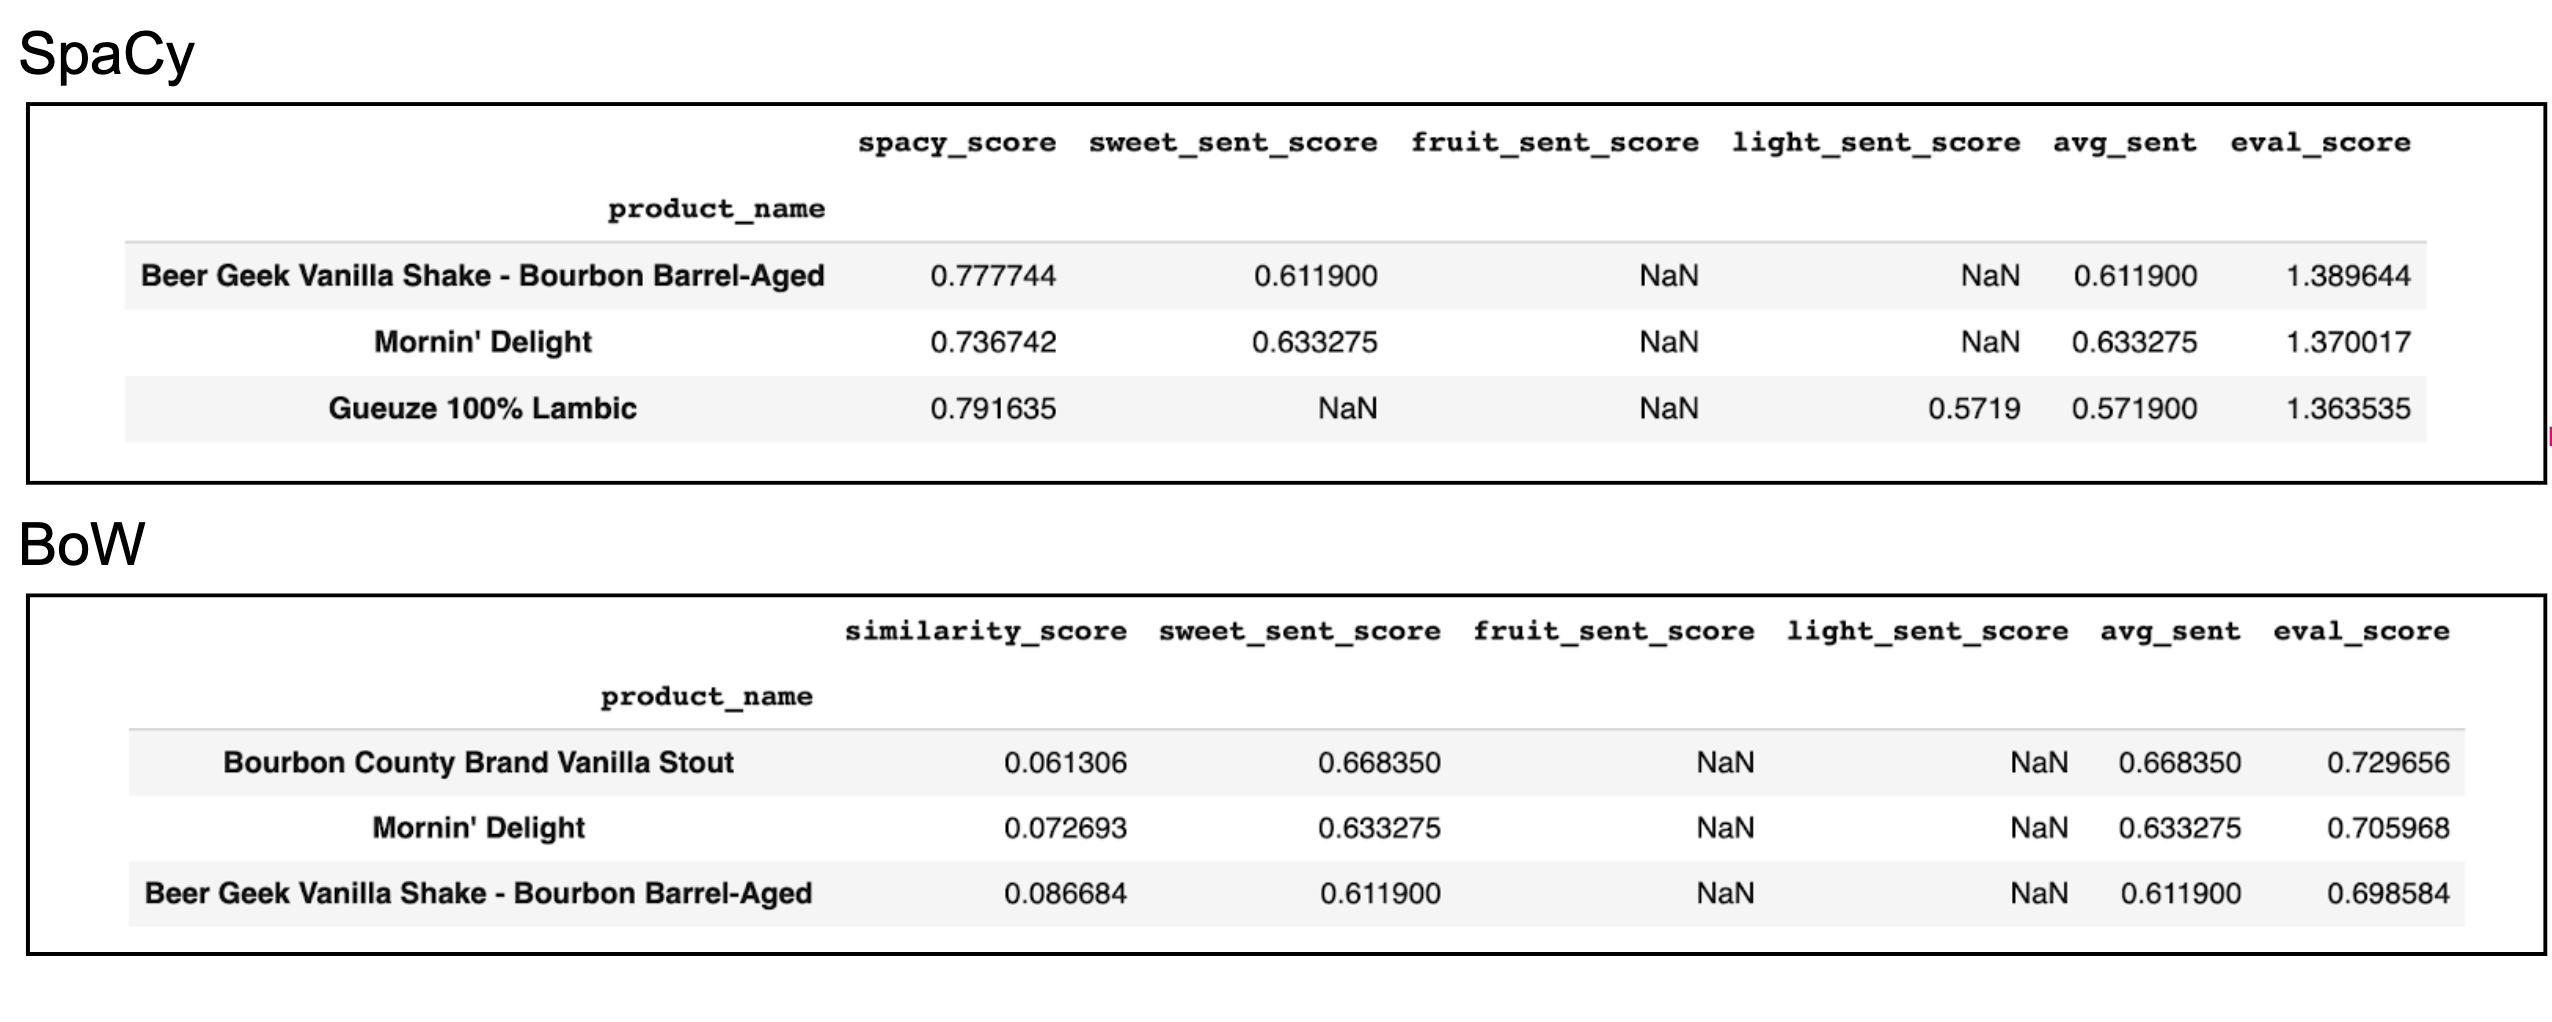


You can see that two of the three beers are the same in both recommendations, but put in slightly different orders. The top beer recommended with SpaCy was the Beer Geek Vanilla Shake - Bourbon Barrel-Aged beer, whereas this beer was the third recommended beer in the BoW recommendations. Similarly, the second recommended beer in both methods was the Mornin’ Delight. When we look at the actual reviews for these beers, the reviews heavily mention the words “sweet”, which explains why each table only have sentiment scores for “sweet” and not “fruit” or “light”. However, this may be the issue with using word embeddings, because it would seem that the best recommendation for beer would be the one that mentions all three attributes, rather than one that strongly mentions only one attribute. In the end, the three beers recommended by both methods are overall very similar and serve to be good recommendations, but it is interesting to compare these recommendations to the beer reviews themselves, because they rely heavily on one attribute rather than all three of them. 


## **Task G - Findings**

**Task G.** How would your recommendations differ if you ignored the similarity and feature sentiment scores and simply chose the 3 highest rated products from your entire dataset? Would these products meet the requirements of the user looking for recommendations? Why or why not? Justify your answer with analysis. Use the similarity and sentiment scores as well as overall ratings (e.g., from the Amazon website) to answer this question.  

\

If we ignored the similarity and feature sentiment scores and simply just chose the 3 highest rated products from the entire dataset, our recommendation changes dramatically. Below, you can find the pivot table we used to determine the top 3 recommendations by highest average beer rating. 

\
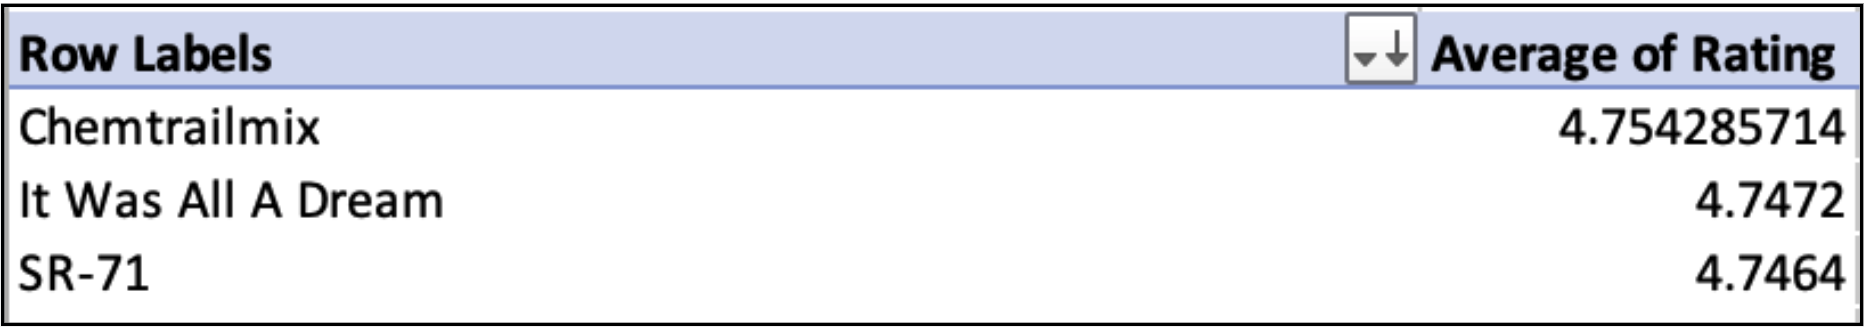

These products would not meet the requirements of the user who is looking for beer recommendations because we did not take into account any of the three attributes that the user chose (sweet, light, fruity). Instead, this list provides the top rated beers overall, not taking any other factors or attributes into account. Compared to the recommendations we devised using the similarity and sentiment scores, the top 3 beer recommendations are drastically different. 

\
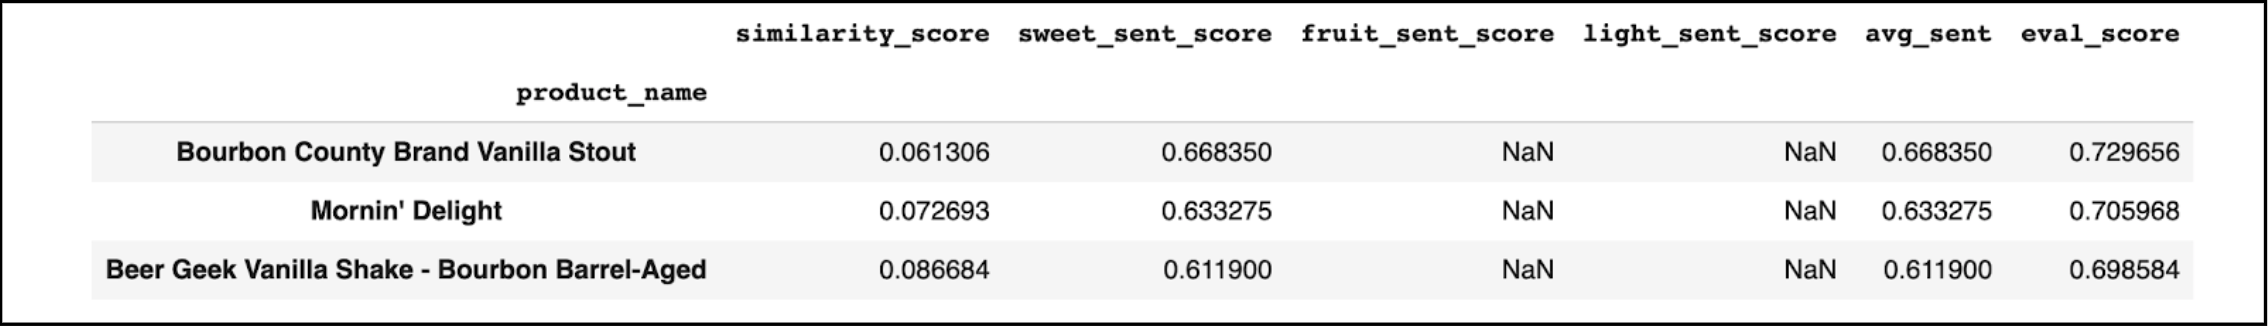

Let’s take a look at a sample of reviews for the top three beers in this recommendation (above) vs. the recommendations in the pivot table. The top recommendation in the pivot table (disregarding similarity and sentiment scores) is the beer Chemtrailmix. This beer is often described using the words “dark”, “spice”, and “cinnamon”, which are all three attributes that are very different from the attributes of our given user (sweet, light, fruity). On the other hand, the top recommendation from our evaluation score is the Bourbon County Brand Vanilla Stout is often described using the words “sweet”, “dark”, and “fruit”, which includes two of the three attributes that our given user desires (sweet and fruit). In this case, although many of the reviews mention “fruit” flavors to describe the beer, the sentiment score for fruit does not reflect this, but the beer scored a high evaluation score due to its high sentiment value for the “sweet” attribute. This recommendation makes a lot more sense than the recommendation given with just the overall rating score, and this is because deeper analysis went into determining whether the beer’s attributes matched up with the attributes given. 

